# Time collapsing emissions data 
This notebook explores the MODIS effective radius data together with emissions data. It is supposed to show which time-interval of emissions around each MODIS image is informative for effective radius changes. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import sys
import datetime
import iris
from pyhdf.SD import SD, SDC
import time
import xarray as xr
from matplotlib.colors import LogNorm
from sklearn.linear_model import LinearRegression
from time_collapse_tools import load_emis, load_modis, coarsened_emis, time_collapse_emis, select_lonlats, select_data, re_diff_emis

from cis import read_data, read_data_list, get_variables

In [2]:
# hour_poll_prist=np.array(hour_poll_prist)
# hour_poll_prist[:,1,:]=np.where(hour_poll_prist[:,2,:]>20, hour_poll_prist[:,1,:], np.nan )
# plt.figure(figsize=(20, 10))
# for day in range(np.shape(hour_poll_prist)[2]):
#     plt.plot(np.linspace(-21, 48, 24), hour_poll_prist[:,1,day], c = plt.cm.viridis(day/np.shape(hour_poll_prist)[2]) )
# plt.plot(np.linspace(-21, 48, 24), np.nanmean(hour_poll_prist[:,1,:], axis=1))

In [3]:
modis_dir='/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/regrid_modis_aqua/'
emis_dir='/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/colloc_emission_modis/downsampled_emis/'
save_dir='/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/colloc_emission_modis/ds_timecoll_emis/'

(array([100525., 295526., 398516., 278753., 192972., 131028.,  83363.,
         52300.,  35232.,  25248.]),
 array([ 3.2273553 ,  4.90461973,  6.58188415,  8.25914858,  9.936413  ,
        11.61367743, 13.29094185, 14.96820628, 16.6454707 , 18.32273513,
        19.99999955]),
 <a list of 10 Patch objects>)

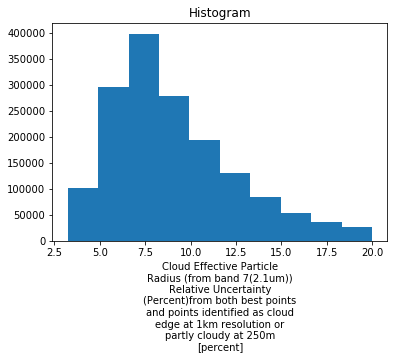

In [4]:
filelist=glob.glob(modis_dir + '2018' + '09' + "*.nc")
ds=xr.open_mfdataset(filelist)
ds['Cloud_Effective_Radius_Uncertainty'].where(ds['Cloud_Effective_Radius_Uncertainty']<20).plot()

In [5]:
da1=load_emis(emis_dir, month='01')
re1=load_modis(modis_dir, month='01')
da2=load_emis(emis_dir, month='02')
re2=load_modis(modis_dir, month='02')
da3=load_emis(emis_dir, month='03')
re3=load_modis(modis_dir, month='03')
da4=load_emis(emis_dir, month='04')
re4=load_modis(modis_dir, month='04')
da5=load_emis(emis_dir, month='05')
re5=load_modis(modis_dir, month='05')
da6=load_emis(emis_dir, month='06')
re6=load_modis(modis_dir, month='06')
da7=load_emis(emis_dir, month='07')
re7=load_modis(modis_dir, month='07')
da8=load_emis(emis_dir, month='08')
re8=load_modis(modis_dir, month='08')
da9=load_emis(emis_dir, month='09')
re9=load_modis(modis_dir, month='09')
da10=load_emis(emis_dir, month='10')
re10=load_modis(modis_dir, month='10')
da11=load_emis(emis_dir, month='11')
re11=load_modis(modis_dir, month='11')
da12=load_emis(emis_dir, month='12')
re12=load_modis(modis_dir, month='12')

0.12199776780100965
0.8354962619125674
0.8403909137338763
0.10190247379302106
0.8249974182810004
0.8296657736956244
0.13413952203873564
0.8552655342897679
0.8581131654474617
0.14488148053653857
0.8094168284881386
0.8128828790520333
0.1193901826224086
0.7852086868296144
0.7884362764799292
0.11321738883927938
0.6824250069689539
0.6870273513722933
0.09168110371769496
0.6603870638536021
0.6675985022959826
0.0855610743269225
0.6569948712461953
0.6605941892412764
0.08721539500975653
0.7084373951703968
0.7119832934094957
0.1579173336515657
0.7746612951235002
0.7778701383259239
0.11819723793189796
0.808631108465271
0.8130293452018161
0.09389501349058403
0.8246004606139415
0.8306491620566407


In [6]:
comb_da=xr.concat([da1, da2, da3, da4, da5, da6, da7, da8, da9, da10, da11, da12], dim='time')
comb_re=xr.concat([re1, re2, re3, re4, re5, re6, re7, re8, re9, re10, re11, re12], dim='time')
# comb_da=xr.concat([dam,da0,da, da2, da3], dim='time')
# comb_re=xr.concat([rem,re0,re, re2, re3], dim='time')

In [7]:
if len(comb_re.coords['time'].values)-len(comb_da.coords['time'].values)/24 > 0: print('Caution! Array lenghts do not match')

In [8]:
# comb_da=xr.concat([da, da2], dim='time')
# comb_re=xr.concat([re, re2], dim='time')

In [9]:
# mask_re=(
#         (comb_re.coords['time']==np.datetime64('2018-09-03T19:02:40.063975000'))
#       & (comb_re.coords['longitude'] < -74.95)
#       & (comb_re.coords['longitude'] > -75.05)
#       & (comb_re.coords['latitude'] < -24.95)
#       & (comb_re.coords['latitude'] > -25.05)
#      )
# manip_re=comb_re.where(np.logical_not(mask_re), 1e8)
# #manip_re.sel(latitude=slice(-26,-24)).mean('time').plot()
# mask_emis=(
#         (comb_da.coords['time']==np.datetime64('2018-09-02T16:00:00.000000000'))
#       & (comb_da.coords['longitude'] < -74.95)
#       & (comb_da.coords['longitude'] > -75.05)
#       & (comb_da.coords['latitude'] < -24.95)
#       & (comb_da.coords['latitude'] > -25.05)
#      )
# manip_emis=comb_da.where(np.logical_not(mask_emis), 1e8)
# #manip_emis.sel(latitude=slice(-26,-24)).mean('time').plot()

In [10]:
# comb_re.coords['time']

In [11]:
month='10'

/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5,1,'Effective Radius in single day')

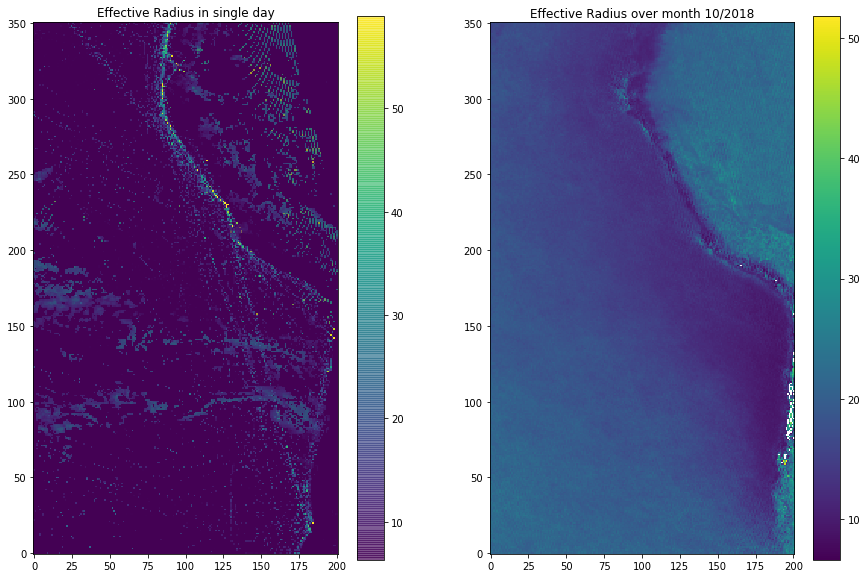

In [12]:
fig=plt.figure(figsize=(15,25))
ax1=fig.add_subplot(1,2,2)
f1=ax1.imshow(comb_re.mean('time').values,origin='lower')
fig.colorbar(f1,ax=ax1,shrink=0.4)
ax1.set_title('Effective Radius over month {}/2018'.format(month))
day=4
ax2=fig.add_subplot(1,2,1)
f2=ax2.imshow(comb_da.groupby('time.day').reduce(np.mean).isel(day=day).values, vmax=0.1, origin='lower')
f2=ax2.imshow(comb_re.isel(time=day).values, origin='lower', alpha=0.7)
fig.colorbar(f2,ax=ax2,shrink=0.4)
ax2.set_title('Effective Radius in single day')

Text(0.5,1,'Effective Radius in single day')

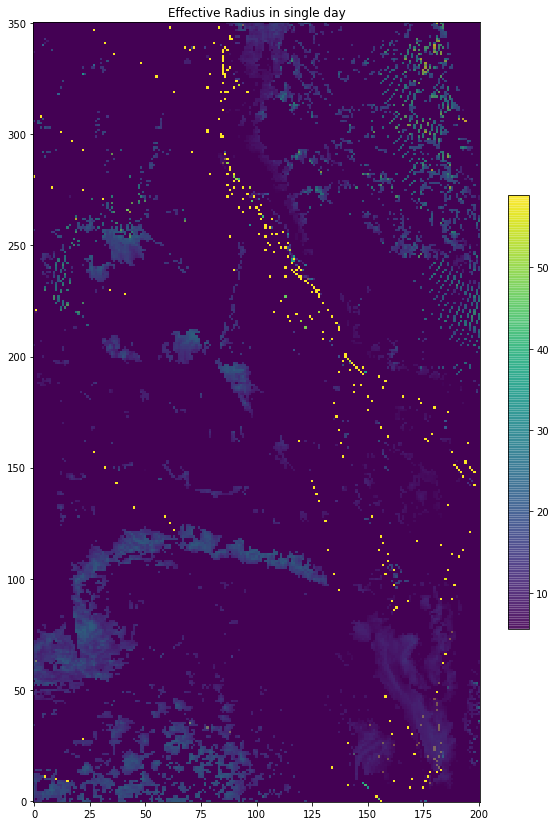

In [13]:
day=13
fig=plt.figure(figsize=(10,20))
ax2=fig.add_subplot(1,1,1)
f2=ax2.imshow(time_collapse_emis(comb_da, hours=15, overpass_hour=18).isel(time=day).values, vmax=0.1, origin='lower')
f2=ax2.imshow(comb_re.isel(time=day).values, origin='lower', alpha=0.7)
fig.colorbar(f2,ax=ax2,shrink=0.4)
ax2.set_title('Effective Radius in single day')

In [14]:
coarse_emis=coarsened_emis(comb_da)

/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


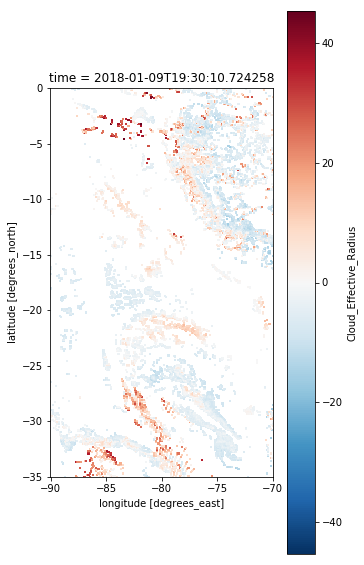

In [15]:
plt.figure(figsize=(5,10))
re_adj=comb_re-comb_re.mean('time')
re_adj.isel(time=8).plot()
plt.axes().set_aspect('equal')

/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5,1,'Mean SOx Emissions in single hour')

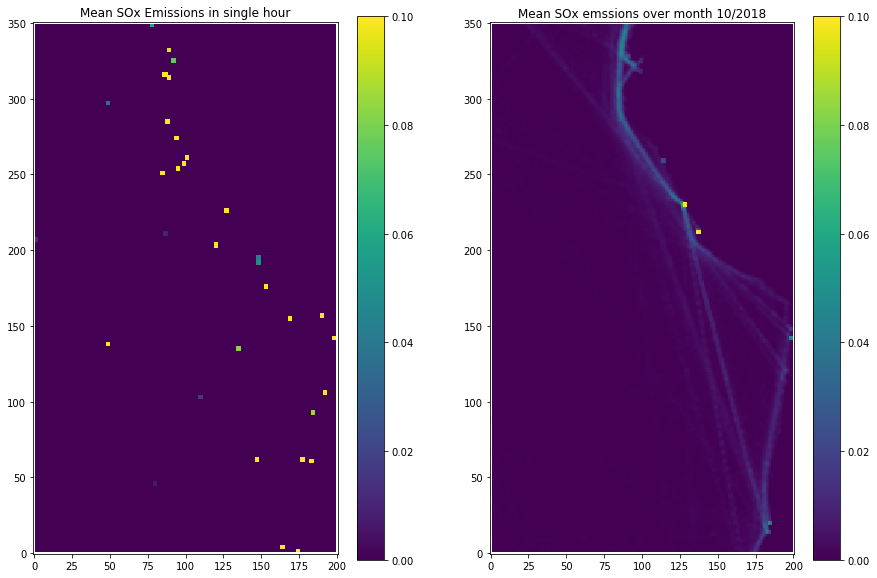

In [16]:
fig=plt.figure(figsize=(15,25))
ax1=fig.add_subplot(1,2,2)
f1=ax1.imshow(coarse_emis.mean('time').values, vmax=0.1, origin='lower')
fig.colorbar(f1,ax=ax1, shrink=0.4)
ax1.set_title('Mean SOx emssions over month {}/2018'.format(month))

ax2=fig.add_subplot(1,2,1)
f2=ax2.imshow(coarse_emis.isel(time=1).values, vmax=0.1, origin='lower')
fig.colorbar(f2,ax=ax2,shrink=0.4)
ax2.set_title('Mean SOx Emissions in single hour')

In [18]:
adj_re=comb_re-comb_re.isel(time=slice(1,len(comb_re.time)-1)).mean('time')
#lats=slice(-35,-17), lons=slice(-77.5,-72.5)
hour_poll_prist=[]
for hour in np.linspace(-21, 48, 24):
    print(hour)
    re_sel, emis_sel=select_data(adj_re,comb_da, emis_h=3,end_h=hour,lats=slice(-35,-17), lons=slice(-77.5,-72.5), coarsening=1)
    re_prist,re_poll, pollpoints, pristpoints, re_pollvar=re_diff_emis(0.0,re_sel, emis_sel)
    hour_poll_prist.append([hour-19, re_prist,re_poll, pollpoints, re_pollvar])

-21.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-18.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-15.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-12.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-9.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-6.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-3.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


3.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


6.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


9.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


12.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


15.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


18.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


21.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


24.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


27.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


30.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


33.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


36.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


39.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


42.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


45.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


48.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [19]:
# np.linspace(-21, 48, 24)

Text(0,0.5,'r_eff')

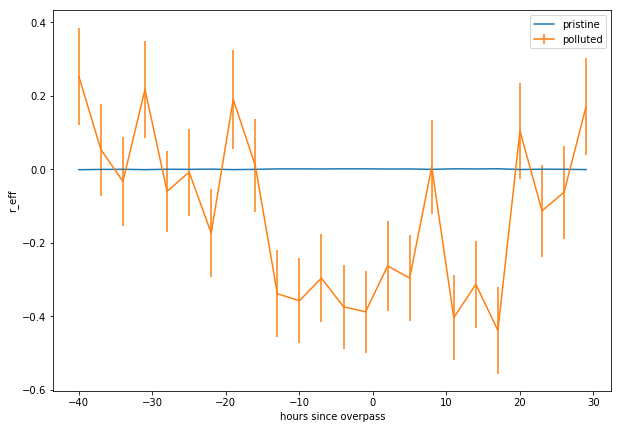

In [20]:
plt.figure(figsize=(10,7))
arr=np.transpose(hour_poll_prist)
plt.plot(arr[0], arr[1])
plt.errorbar(arr[0], arr[2], np.sqrt(arr[4]/arr[3]))
plt.legend(['pristine', 'polluted'])
plt.xlabel('hours since overpass')
plt.ylabel('r_eff')

Text(0.5,1,'Mean SOx Emissions in observation period')

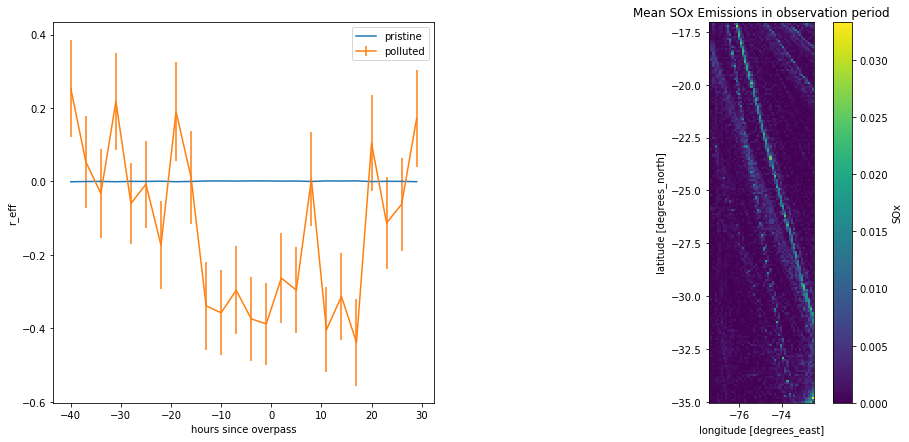

In [21]:
fig=plt.figure(figsize=(15,7))
ax1=fig.add_subplot(1,2,1)
ax1.plot(arr[0], arr[1])
ax1.errorbar(arr[0], arr[2], np.sqrt(arr[4]/arr[3]))
ax1.legend(['pristine', 'polluted'])
ax1.set_xlabel('hours since overpass')
ax1.set_ylabel('r_eff')

ax2=fig.add_subplot(1,2,2)
comb_da.sel(latitude=slice(-35,-17), longitude=slice(-77.5,-72.5)).mean('time').plot()
ax2.set_aspect('equal')
ax2.set_title('Mean SOx Emissions in observation period')


In [22]:
relate,emlate=select_data(adj_re,comb_da, emis_h=10,end_h=47,lats=slice(-35,-17), lons=slice(-77.5,-72.5))

In [23]:
reearl,emearl=select_data(adj_re,comb_da, emis_h=10,end_h=19,lats=slice(-35,-17), lons=slice(-77.5,-72.5))

/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


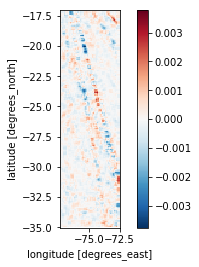

In [24]:
(emearl.mean('time')-emlate.mean('time')).plot()
plt.axes().set_aspect('equal')

Text(0,0.5,'number of data points')

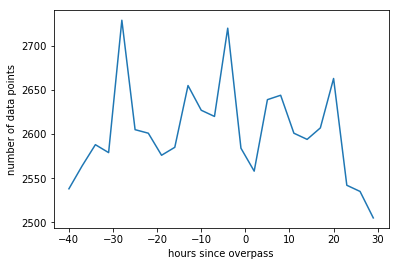

In [25]:
arr=np.transpose(hour_poll_prist)
plt.plot(arr[0], arr[3])
plt.xlabel('hours since overpass')
plt.ylabel('number of data points')

In [ ]:
re_sel, emis_sel=select_data(adj_re,comb_da, 
                             emis_h=20,end_h=29,
                             lats=slice(-35,-17), lons=slice(-77.5,-72.5),
                             coarsening=1)

In [ ]:
X=emis_sel.values.flatten()
Y=re_sel.values.flatten()

In [ ]:
plt.figure(figsize=(10,7))
#range=[[0.0, 2], [-30, 30]]
plt.hist2d(X,Y, bins=30,range=[[0.0, 2], [-30, 30]],norm=LogNorm())
plt.ylabel('r_eff')
plt.xlabel('emissions in the past 7h')
plt.colorbar()

In [ ]:
X=X[np.logical_not(np.isnan(Y))]
Y=Y[np.logical_not(np.isnan(Y))]

In [ ]:
X_t=np.where(X>0.0, 1, 0)
n=len(Y)
regr = LinearRegression(
   fit_intercept = True).fit(X_t.reshape(-1, 1),Y)
print(regr.coef_)
RSS_2=((regr.predict(X_t.reshape(-1, 1)) - Y) ** 2).sum()
RSS_1=((Y-np.mean(Y))**2).sum()
F=((RSS_1-RSS_2)/1)/(RSS_2/(n-2))
F

In [ ]:
re_diff_emis(0.0,re,emis)

In [ ]:
re_mean=re_emis_bins(re, emis, 0.5, 20)

In [ ]:
fig=plt.figure(figsize=(20,6))

ax1=fig.add_subplot(1,2,1)
ax1.plot(re_mean[0],re_mean[1])
plt.xlabel('emissions')
plt.ylabel('r_eff')



ax2=fig.add_subplot(1,2,2, sharex=ax1)
ax2.plot(re_mean[0],np.log10(re_mean[2]))
plt.xlabel('emissions')
plt.ylabel('log(n points)')

In [ ]:
# def pop_history_callback(cube, field, filename):
#     cube.attributes.pop("history")
#     return cube

# dati=iris.load('/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/regrid_modis/*.nc',
#                   ['Cloud_Top_Temperature',
#                 'Cloud_Effective_Radius'])
#collocate instead of merge

In [ ]:
#emis_plus_cloud=xr.merge([re._to_temp_dataset(), emis_coarsened._to_temp_dataset()])

In [ ]:
# emis_plus_cloud.plot.scatter(x='SOx', y='Cloud_Effective_Radius')

In [ ]:
fig=plt.figure(figsize=(20,6))

ax1=fig.add_subplot(1,2,1)
ax1.plot(re_mean[0],re_mean[1])


ax2=fig.add_subplot(1,2,2, sharex=ax1)
ax2.plot(re_mean[0],np.log10(re_mean[2]))

In [ ]:
for threshold in np.linspace(0,1,20):
    print(threshold)
    print(re_diff_emis(threshold, re.sel(longitude=slice(-90,-72.5),latitude=slice(-35,-18)), emis_coarsened.sel(longitude=slice(-90,-72.5),latitude=slice(-35,-18))))

In [ ]:
#different time-windows
#coarser resolution
#spreading with time
#discounting with time